# Superstore Data Analysis
(**Python, pandas, matplotlib, SQL**)

In this notebook we analyse the [Superstore dataset](https://www.kaggle.com/datasets/vivek468/superstore-dataset-final).
First we clean the data if needed and have a first look at some basic statistics using **pandas**. Then we have a closer look at the data using **SQL** queries to identify ways to increase profit.

## Importing necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

## Cleaning the data

In [ ]:
df = pd.read_csv("Sample - Superstore.csv", encoding = 'latin1')

In [ ]:
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [ ]:
# Rename columns: remove leading and trailing spaces, capital letters, replace spaces with underscore
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

df.head(0)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit


In [ ]:
# Checking for missing values
df.isnull().sum()

,0
row_id,0
order_id,0
order_date,0
ship_date,0
ship_mode,0
customer_id,0
customer_name,0
segment,0
country,0
city,0


There were no missing values. If there were any we would use `df.dropna()` or `df.fillna()` to delete rows with missing data or fill the missing values with something appropriate.

In [ ]:
# Convert date format to work properly with postgresql
print("Date format before: " + str(df["order_date"][1]))

df['order_date'] = pd.to_datetime(df['order_date'], format='%m/%d/%Y')
df['ship_date'] = pd.to_datetime(df['ship_date'], format='%m/%d/%Y')

print("Date format after: " + str(df["order_date"][1]))

Date format before: 11/8/2016
Date format after: 2016-11-08 00:00:00


In [ ]:
# Check for duplicates

df.duplicated().sum()

np.int64(0)

There are no duplicate rows. If there were any we would use `df.drop_duplicates()`

There is one issue that needs to be resolved before importing our data to postgresql. One of the product names end with an apostrophe that causes issues.
We search for the problematic row and correct the product name for all instances.

In [ ]:
df.loc[
    (df["order_date"] == "2017-06-29") &
    (df["customer_name"] == "Alex Avila") &
    (df["ship_date"] == "2017-07-04")
]

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
1159,1160,CA-2017-147039,2017-06-29,2017-07-04,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,...,55407,Central,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'",362.94,3,0.0,90.735
1160,1161,CA-2017-147039,2017-06-29,2017-07-04,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,...,55407,Central,OFF-BI-10004654,Office Supplies,Binders,Avery Binding System Hidden Tab Executive Styl...,11.54,2,0.0,5.770


In [ ]:
# Rename the product
df.loc[df['product_id'] == 'OFF-AP-10000576', 'product_name'] = (
    df.loc[df['product_id'] == 'OFF-AP-10000576', 'product_name']
    .str.replace(r"'$", "ft", regex=True)
)

print("New product name: " + df.iloc[1159,16])

New product name: Belkin 325VA UPS Surge Protector, 6ft


## Describe the data
We use `df.describe()` to have a first look at some basic statistics.

In [ ]:
df[['order_date', 'ship_date', 'sales', 'quantity', 'discount', 'profit']].describe()

,order_date,ship_date,sales,quantity,discount,profit
count,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000
mean,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,229.858001,3.789574,0.156203,28.656896
min,2014-01-03 00:00:00,2014-01-07 00:00:00,0.444000,1.000000,0.000000,-6599.978000
25%,2015-05-23 00:00:00,2015-05-27 00:00:00,17.280000,2.000000,0.000000,1.728750
50%,2016-06-26 00:00:00,2016-06-29 00:00:00,54.490000,3.000000,0.200000,8.666500
75%,2017-05-14 00:00:00,2017-05-18 00:00:00,209.940000,5.000000,0.200000,29.364000
max,2017-12-30 00:00:00,2018-01-05 00:00:00,22638.480000,14.000000,0.800000,8399.976000
std,NaN,NaN,623.245101,2.225110,0.206452,234.260108


**Order and Ship Date**
-   the dataset includes order from 2014 to end of 2017

**Sales**
- Sales range from \$0.44 to \$22,638.48
- The mean sale is about \$229.86, but the median is much lower (\$54.49), indicating a right-skewed distribution (some very large sales pulling the average up).
- High std (623) confirms wide variation in sale amounts.

**Quantity**
- Ranges from 1 to 14 items per order
- Most orders are small: median is 3, 75% of orders are 5 or fewer items
- Relatively low variation (std = 2.2)

**Discount**

-    Values range from 0.0 to 0.8 (i.e., 0% to 80% discount)
-    Most orders receive 0% or 20% discount (as seen by 25%, 50%, and 75% quantiles)
-    Some rare high discounts exist

**Profit**

-    Big red flag: minimum profit is –6,599.98, maximum is 8,399.98
-    Average profit is $28.66, but some orders are heavily unprofitable
-    High standard deviation (234) → profit distribution is wide

In [ ]:
# Save the cleaned dataset
df.to_csv('superstore_clean.csv', index=False, date_format='%Y-%m-%d')

Since this table has a lot of columns, we split it up into multiple tables, just to be able to use JOINs in SQL.

In [ ]:
orders_df = df[['order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id', 'country', 'city', 'state', 'postal_code', 'region']].drop_duplicates()

customers_df = df[['customer_id', 'customer_name', 'segment']].drop_duplicates()

products_df = df[['product_id', 'product_name', 'category', 'sub-category']].drop_duplicates(subset=['product_id'], keep='first')

order_items_df = df[['row_id', 'order_id', 'product_id', 'sales', 'quantity', 'discount', 'profit']]

In [ ]:
orders_df.to_csv('orders.csv', index=False, date_format='%Y-%m-%d')
customers_df.to_csv('customers.csv', index=False)
products_df.to_csv('products.csv', index=False)
order_items_df.to_csv('order_items.csv', index=False)

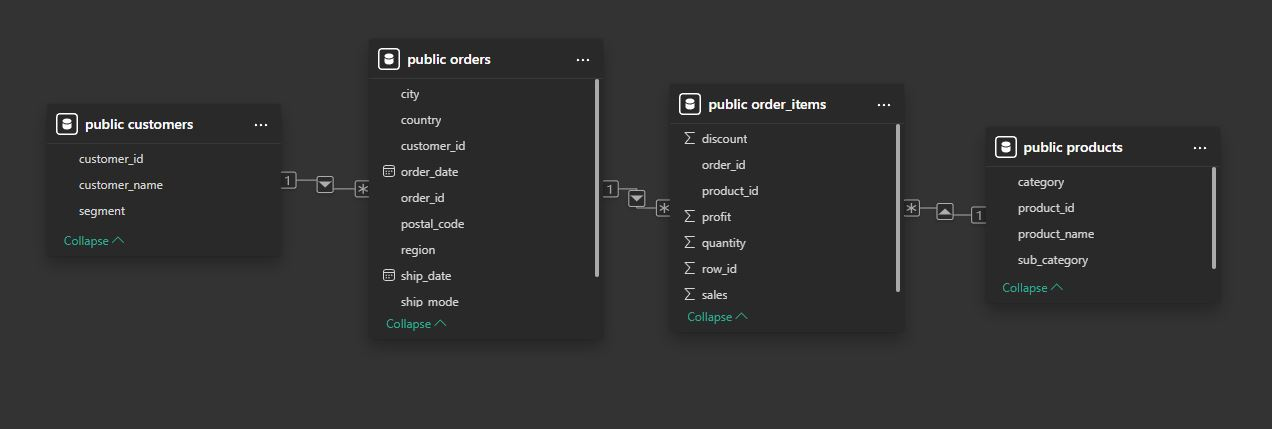

In [ ]:
display(Image(filename='model.JPG'))

## SQL and Visualizations

### Creating Tables

In postgresql we create tables and add indexes to frequently used joins and filters to improve performance.

```sql
CREATE TABLE orders (
    order_id VARCHAR NOT NULL,
    order_date DATE,
    ship_date DATE,
    ship_mode VARCHAR,
    customer_id VARCHAR,
    country VARCHAR,
    city VARCHAR,
    state VARCHAR,
    postal_code VARCHAR,
    region VARCHAR,
    PRIMARY KEY (order_id)
);


CREATE INDEX idx_orders_customer_id ON orders(customer_id);
CREATE INDEX idx_orders_order_id ON orders(order_id);
```

```sql
CREATE TABLE customers (
    customer_id VARCHAR PRIMARY KEY,
    customer_name VARCHAR,
    segment VARCHAR
);
```

```sql
CREATE TABLE products (
    product_id VARCHAR PRIMARY KEY,
    product_name VARCHAR,
    category VARCHAR,
    sub_category VARCHAR
);
```

```sql
CREATE TABLE order_items (
    row_id INT PRIMARY KEY,
    order_id VARCHAR NOT NULL,
    product_id VARCHAR NOT NULL,
    sales NUMERIC,
    quantity INT,
    discount NUMERIC,
    profit NUMERIC
);


CREATE INDEX idx_order_items_order_id ON order_items(order_id);
CREATE INDEX idx_order_items_product_id ON order_items(product_id);
```

### Analyzing Discounts

-------------------------------------------------------------
Our goals are:
- determine where the company is losing profit
- what are the most profitable areas / products
- what can be done based on findings to improve profits

#### Query 1: Orders with negative profit

First we simply look at individual orders where the profit is negative:

```sql
SELECT o.order_id, oi.product_id,p.product_name, o.state, oi.discount, oi.profit
FROM orders o JOIN order_items oi USING(order_id) JOIN products p USING(product_id)
WHERE oi.profit < 0
ORDER BY oi.profit ASC;
```

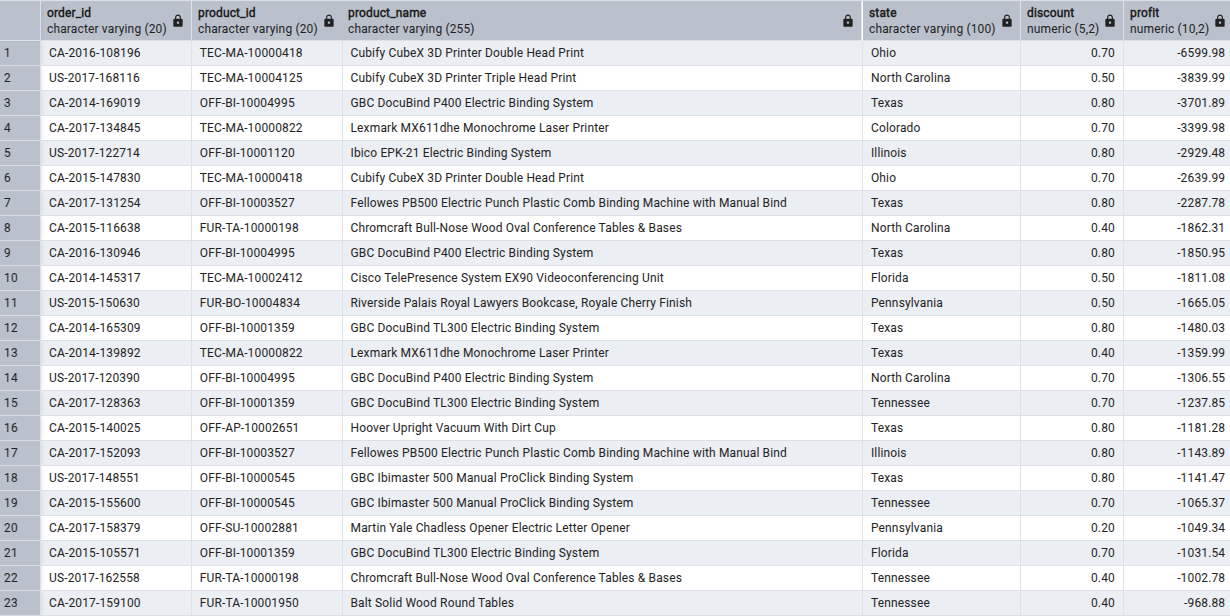

In [ ]:
display(Image(filename='q1.png'))

By looking at the results we see that most orders have a high discount, while our initial description of the data showed that most orders have a discount of 0 or 20%.

High discounts of course mean low or even negative profit for a specific order, but they are good for rewarding customers for repeated or high volume orders that would generate more profit in the long term.



#### Query 2: Average Profit by Discount

In the next steps we investigate how discounts effect profits, and if giving discounts is worth it in the long run.

First we look at the average profit by discount.

```sql
SELECT oi.discount, ROUND(AVG(oi.sales),2) AS sales, ROUND(AVG(oi.profit),2) AS profit
FROM order_items oi
GROUP BY oi.discount
ORDER BY AVG(oi.profit) ASC;
```

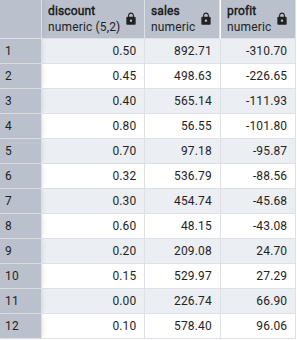

In [ ]:
display(Image(filename='q2.png'))

From this we can see that the company loses the most profit on orders with around 40-50% discounts, and we also see that orders with 10% discounts are even more profitable than no discounts.


#### Query 3: States with Lowest Profits

Next we look at the geographical distribution of profits, identifying the least profitable states.

```sql
SELECT o.state, o.region, SUM(oi.sales) AS sales, SUM(oi.profit) AS profit
FROM orders o JOIN order_items oi USING(order_id)
GROUP BY o.state, o.region
ORDER BY SUM(oi.profit) ASC;
```

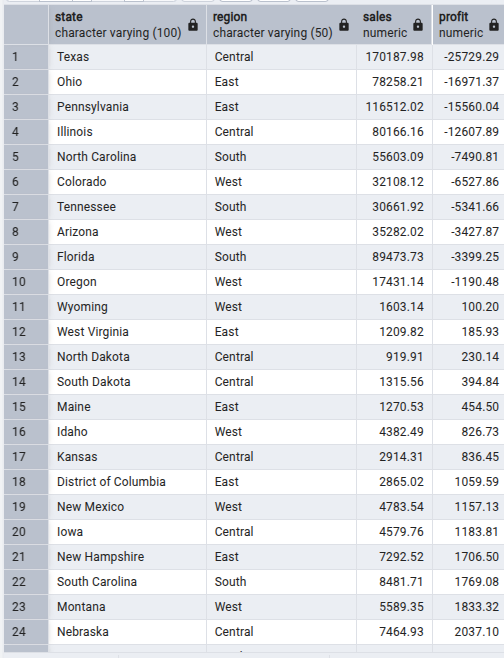

In [ ]:
display(Image(filename='q3.png'))

We can see that there are 10 states that are in the negative.

#### Query 4: Discount rates and profit

Now we look at the proportion of discounts within all orders for each state to see if we can explain poor performance with too many discounts.

```sql
SELECT o.state,
ROUND(SUM(CASE WHEN oi.discount > 0 THEN 1 ELSE 0 END) / COUNT(*)::numeric,4) AS rate_discounted_orders,
SUM(oi.profit) AS profit
FROM orders o JOIN order_items oi USING(order_id)
GROUP BY o.state
ORDER BY SUM(oi.profit);
```

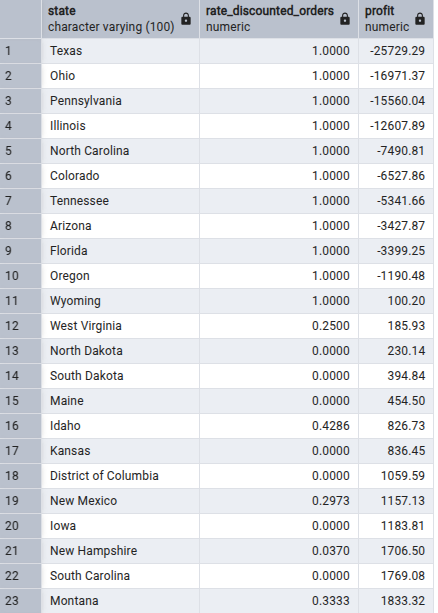

In [ ]:
display(Image(filename='q4.png'))

We can see that states that have negative profit all have a 100% discount rate, meaning every single order had some amount of discount. Other state with positive profit have much lower, and even 0% discount rate.

The following image of the same query also shows that the highest performing states do not have 0% but around 30% discount rate.

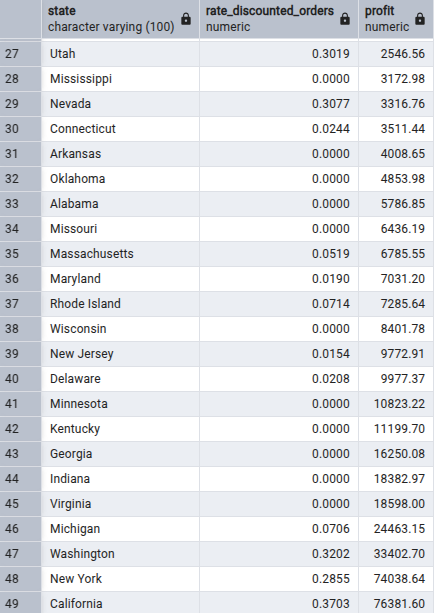

In [ ]:
display(Image(filename='q4_2.png'))

#### Visualization: Distribution of discounts in top and worst performing states

Based on previous queries we can assume that the discounts given in top perfroming states are lower (around 10%), and that there are a lot more mid and high discounts (40-80%) are given in states with low profit.

We investigate this assumption next. We could write a query but to make it clear we use matplotlib to visualize the distribution of discount in the top and bottom states based on profit. We take the average amount of orders in the 3 states.

<ipython-input-21-8a6c310571e9>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_dist = filtered_df.groupby(['state_group', 'discount_bin']).size().unstack().fillna(0)


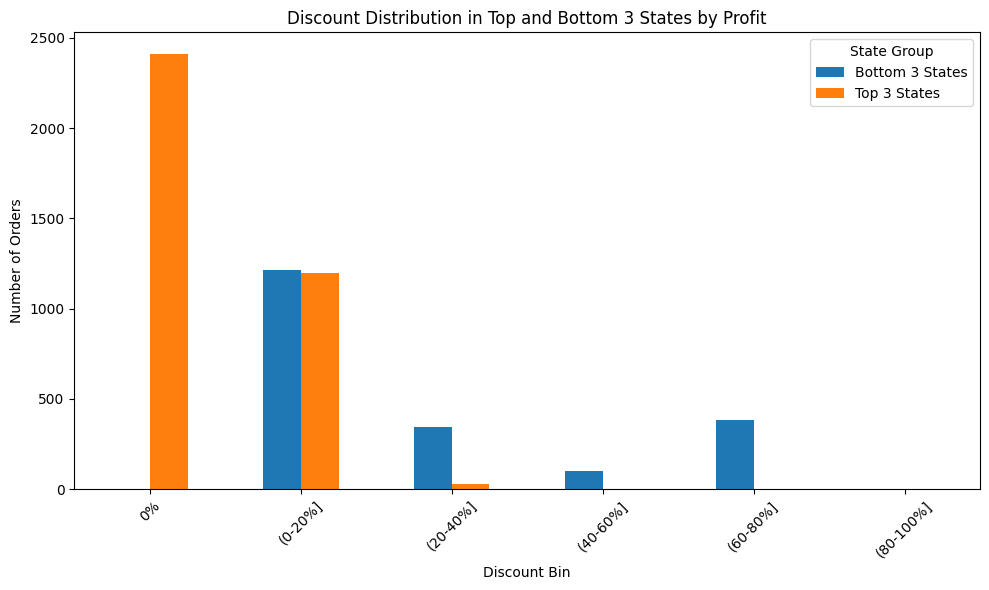

In [ ]:
merged_df = orders_df.merge(order_items_df, on='order_id')

# Get total profit by state
state_profit = merged_df.groupby('state')['profit'].sum().sort_values(ascending=False)

# Get top and bottom 3 states
top_3_states = state_profit.head(3).index.tolist()
bottom_3_states = state_profit.tail(3).index.tolist()

filtered_df = merged_df[merged_df['state'].isin(top_3_states + bottom_3_states)].copy()

# Creating bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['(0-20%]', '(20-40%]', '(40-60%]', '(60-80%]', '(80-100%]']
filtered_df['discount_bin'] = pd.cut(
    filtered_df['discount'], bins=bins, labels=labels, include_lowest=False, right=True
)


filtered_df['discount_bin'] = filtered_df['discount_bin'].cat.add_categories(['0%'])
filtered_df.loc[filtered_df['discount'] == 0, 'discount_bin'] = '0%'

ordered_bins = ['0%', '(0-20%]', '(20-40%]', '(40-60%]', '(60-80%]', '(80-100%]']
filtered_df['discount_bin'] = pd.Categorical(
    filtered_df['discount_bin'],
    categories=ordered_bins,
    ordered=True
)

filtered_df['state_group'] = filtered_df['state'].apply(
    lambda x: 'Top 3 States' if x in top_3_states else 'Bottom 3 States'
)

discount_dist = filtered_df.groupby(['state_group', 'discount_bin']).size().unstack().fillna(0)

# Plot
discount_dist.T.plot(kind='bar', figsize=(10, 6))
plt.title('Discount Distribution in Top and Bottom 3 States by Profit')
plt.xlabel('Discount Bin')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.legend(title='State Group')
plt.tight_layout()
plt.show()


#### Query 5: Correlation of discounts and profits

To confirm we calculate the correlation between discount and profit.

```sql
SELECT CORR("discount_rate", "profit") AS correlation_discount_profit
FROM (
    SELECT SUM(CASE WHEN oi.discount > 0 THEN 1 ELSE 0 END) AS discount_rate,
	SUM(profit) AS profit
    FROM order_items oi JOIN orders o USING(order_id)
    WHERE discount > 0
	GROUP BY o.state
) AS s;
```

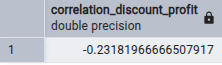

In [ ]:
display(Image(filename='q5.png'))

This shows a weak negative correlation, however if we look at the correlation restricted to discounts >= 40%, we can see a lot stronger correlation:

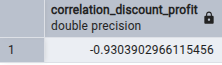

In [ ]:
display(Image(filename='q5_2.png'))

From this we can clearly see that discounts are too aggressive across the board and are note beneficial for the company.

We also have to make sure that the lower discounts are profitable not just overall as shown in Query 2, but in most states individually.

```sql
SELECT o.state, oi.discount, ROUND(AVG(oi.sales),2) AS sales, ROUND(AVG(oi.profit),2) AS profit
FROM order_items oi JOIN orders o USING(order_id)
GROUP BY o.state, oi.discount HAVING oi.discount BETWEEN 0.1 AND 0.2
ORDER BY AVG(oi.profit) DESC;
```

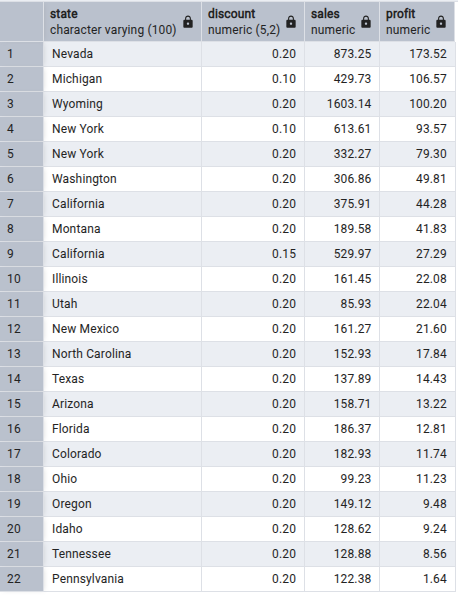

In [ ]:
display(Image(filename='q5_3.png'))

We see that only two states actually had 10% discounts and they are in the top profitable states. This explains the average profit of these orders are higher than of the 0% discount orders, shown in Query 2.

But we do confirm that lower discount orders are still profitable in every state.

### Analyzing Trends


To decide on steps for the future we need to see how the trend is going. These numbers are can be misleading if certain state become more and more profitable over time, but overall might still be in the negative. To visualize, we create graphs how profitability change over the years in these states. For now we focus on the least 4 profitable states.

<Figure size 1000x600 with 0 Axes>

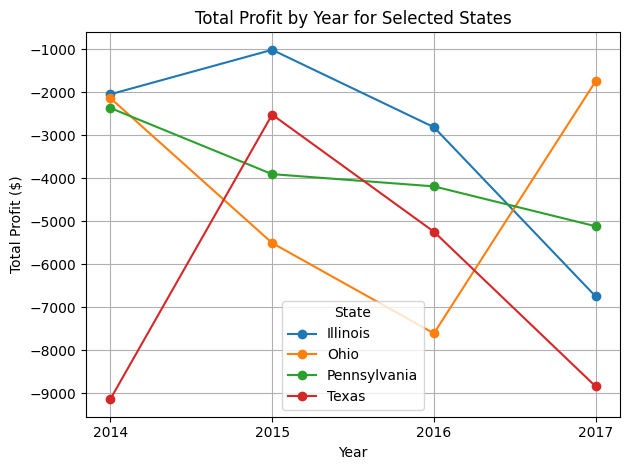

In [ ]:
merged_df = pd.merge(order_items_df, orders_df[['order_id', 'order_date', 'state']], on='order_id', how='left')

# Filter states
selected_states = ['Texas', 'Ohio', 'Pennsylvania', 'Illinois']
filtered_df = merged_df[merged_df['state'].isin(selected_states)].copy()

# Extract year
filtered_df['year'] = filtered_df['order_date'].dt.year

# Group, and sum the profit
profit_by_state_year = filtered_df.groupby(['state', 'year'])['profit'].sum().reset_index()

pivot_df = profit_by_state_year.pivot(index='year', columns='state', values='profit')

# Plot
plt.figure(figsize=(10, 6))
pivot_df.plot(marker='o')

plt.xticks(ticks=pivot_df.index, labels=pivot_df.index.astype(int))

plt.title('Total Profit by Year for Selected States')
plt.xlabel('Year')
plt.ylabel('Total Profit ($)')
plt.grid(True)
plt.legend(title='State')
plt.tight_layout()
plt.show()

For Illinois, Pennsylvania and Texas we can see a stead decline since 2015, however Ohio had a large increase in profit from 2016 to 2017. If it continues it will be profitable by 2018. Ohio's previous underperformance can also be explained by the one order with the highest loss that brought the average down.

The other three states however are on a continuous decline.

### Query 6: Sales and Profit within Region

We investigate how sales volume of these underperforming states compares to other states in the region. For sake of brevity we focus on Central region only.

```sql
SELECT state, SUM(sales) AS total_sales, SUM(profit) AS total_profit
FROM orders o
JOIN order_items oi USING(order_id)
WHERE region = 'Central'
GROUP BY state
ORDER BY SUM(sales) DESC;
```

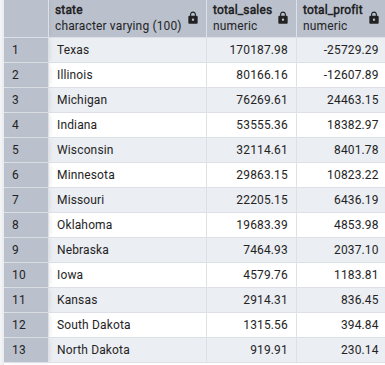

In [ ]:
display(Image(filename="q6.png"))

This query showed us that Texas and Illinois have the highest amount of sales in the region. Meaning that low sales amount is not the issue.

### Query 7: Products by Category

Next we have a look at the items sold by category and sub-category. This could help us determine if there are specific category of items that generate loss.

```sql
SELECT p.category, p.sub_category, SUM(oi.profit) AS total_profit, SUM(oi.sales) AS total_sales
FROM orders o
JOIN order_items oi USING(order_id)
JOIN products p USING(product_id)
WHERE o.state = 'Texas'
GROUP BY p.category, p.sub_category
ORDER BY SUM(oi.profit);
```

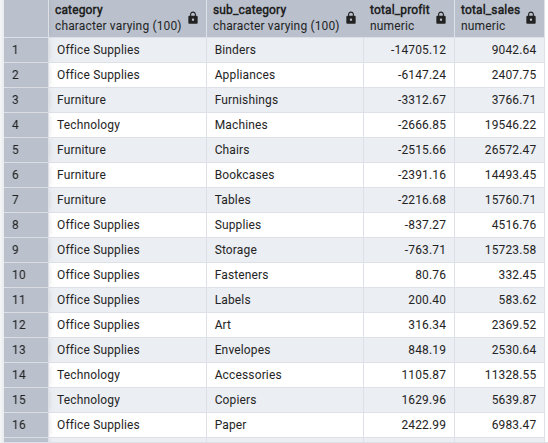

In [ ]:
display(Image(filename="q7.png"))

In Texas, Office supplies, in particular Binders generate a high amount of loss. Removing these items or repricing them would help decrease this loss. Not shown here, but the same also applies to the state of Illinois.

### Query 8: Analyzing Customers

We have a look at the customers in the state of Texas to find out if there are a few customers who generate high amount of loss.

```sql
SELECT c.customer_name, c.segment, SUM(oi.sales) AS sales, SUM(oi.profit) AS profit
FROM orders o
JOIN order_items oi USING(order_id)
JOIN customers c USING(customer_id)
WHERE o.state = 'Texas'
GROUP BY c.customer_name, c.segment
ORDER BY profit ASC;
```

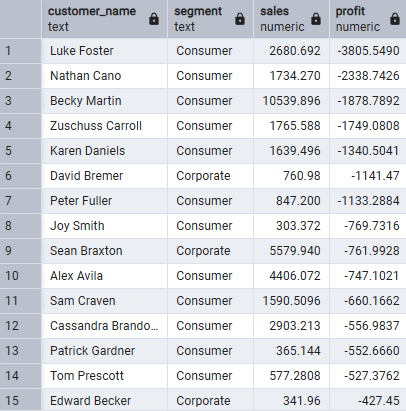

In [ ]:
display(Image(filename="q8.png"))

Looking closer at high loss customers, we discover that they are not consistently generating loss, but rather have one order that explains the high loss on their account.

```sql
SELECT c.customer_name,o.order_id, oi.discount, oi.profit
FROM order_items oi JOIN orders o USING(order_id) JOIN customers c USING(customer_id)
WHERE c.customer_name = 'Luke Foster'
ORDER BY oi.profit;
```

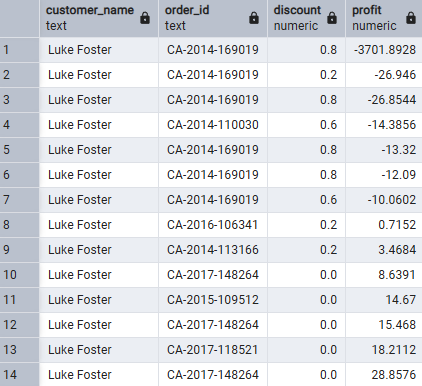

In [ ]:
display(Image(filename="q8_2.PNG"))

Displaying the orders with the highest loss in Texas with some information shows us that that sale of binders, in particular the product 'GBC DocuBind P400 Electric Binding System' appears multiple times in these orders.

```sql
SELECT
    o.order_id,
    o.order_date,
    o.ship_date,
    c.customer_id,
    c.customer_name,
    oi.product_id,
    p.product_name,
    p.category,
    p.sub_category,
    oi.sales,
    oi.quantity,
    oi.discount,
    oi.profit,
    o.state
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.state = 'Texas'
ORDER BY oi.profit ASC
LIMIT 10;
```

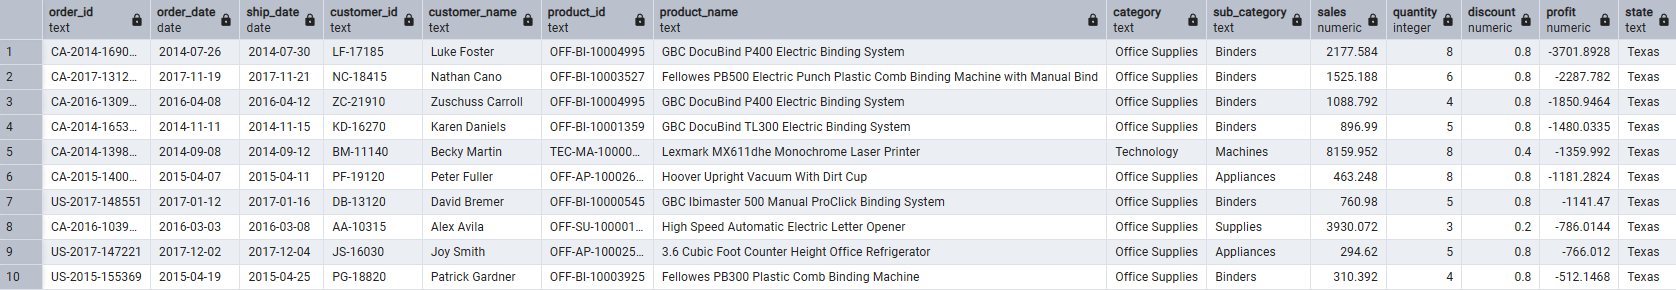

In [ ]:
display(Image(filename="q8_3.PNG"))

After having a closer look at the product in question we can see that it is not only making loss in Texas, but also overall in every state.

```sql
SELECT
    'Overall' AS region,
    p.product_id,
    p.product_name,
    SUM(oi.profit) AS total_profit
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
WHERE oi.product_id = 'OFF-BI-10004995'
GROUP BY p.product_id

UNION ALL

SELECT
    'Texas' AS region,
    p.product_id,
    p.product_name,
    SUM(oi.profit) AS total_profit
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN orders o ON oi.order_id = o.order_id
WHERE oi.product_id = 'OFF-BI-10004995' AND o.state = 'Texas'
GROUP BY p.product_id;

```

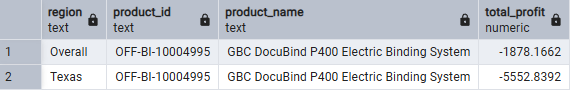

In [ ]:
display(Image(filename="q8_4.PNG"))

## Conclusion

From the analysis we can conclude the following insights:

- Lowest performing states are : Texas, Ohio, Pennsylvania and Illinois. However, Ohio reduced their losses in the last year and if the trend continues it might be profitable next year.
- These states have high sales amount, but of these sales are not profitable.

- Discounts:
  - Some states like the ones mentioned above and many other have discounts on every order. Many of them are as high as 70-80%, and their frequency is much higher than in other states.
  - All of these states are making a loss. Every other state that only has 0-30% of the orders discounted are making profit.

- Products:
  - Binders are highest loss-making products in underperforming states like Texas and Illinois.
  - In particular one product, 'GBC DocuBind P400 Electric Binding System' is highly unprofitable not just in Texas, but overall in every state. Sale of this item in the future is not recommended.
  - Other items, such as 'Cubify CubeX 3D Printer Double Head Print' is also a recurring item in high loss orders in other states.
  - It is likely that there are other selected few items that hurt profits. A more detailed analysis might be beneficial.

- Customers:
  - Overall loss generating customers are not consistently making loss on every order, but rather on a few orders including problematic products mentioned above.


## Other SQL Queries (Window functions, CTEs)
In this last section there are other queries, not necessarily related to the analysis, they are purely here to demonstrate some skills with bit more complex queries, but functionally would not fit into previous sections.

### 3 month running average profit

```sql
SELECT DATE_TRUNC('month',o.order_date) AS month,
	SUM(oi.sales) AS sales,
	SUM(oi.profit) AS profit,
	ROUND(AVG(SUM(oi.profit)) OVER (ORDER BY DATE_TRUNC('month', o.order_date)
	ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),2) AS rolling_3m_avg_profit
FROM order_items oi JOIN orders o ON oi.order_id = o.order_id
GROUP BY month
ORDER BY month;
```

### Customers with Growing Monthly Sales
Customers who have increasing sales month-over-month using LAG

```sql
WITH monthly_sales AS (
  SELECT
    c.customer_id,
    c.customer_name,
    DATE_TRUNC('month', o.order_date) AS month,
    SUM(oi.sales) AS total_sales
  FROM customers c
  JOIN orders o USING(customer_id)
  JOIN order_items oi USING(order_id)
  GROUP BY c.customer_id, c.customer_name, month
),
sales_with_growth AS (
  SELECT *,
    LAG(total_sales) OVER (PARTITION BY customer_id ORDER BY month) AS prev_sales
  FROM monthly_sales
)
SELECT *
FROM sales_with_growth
WHERE prev_sales IS NOT NULL AND total_sales > prev_sales;
```

### Average Discount by Segment with Deviation
Average discount by segment and each customer's deviation from it

```sql
WITH avg_discount_per_segment AS (
  SELECT
    segment,
    AVG(oi.discount) AS avg_discount
  FROM customers c
  JOIN orders o USING(customer_id)
  JOIN order_items oi USING(order_id)
  GROUP BY segment
),
customer_discounts AS (
  SELECT
    c.customer_id,
    c.segment,
    AVG(oi.discount) AS customer_avg_discount
  FROM customers c
  JOIN orders o USING(customer_id)
  JOIN order_items oi USING(order_id)
  GROUP BY c.customer_id, c.segment
)
SELECT
  cd.customer_id,
  cd.segment,
  cd.customer_avg_discount,
  ad.avg_discount,
  ROUND(cd.customer_avg_discount - ad.avg_discount, 4) AS discount_deviation
FROM customer_discounts cd
JOIN avg_discount_per_segment ad USING(segment);
```

### Order Fulfillment Delay Analysis
Average delay between order and ship date, ranked by states with the worst fulfillment times

```sql
WITH order_delays AS (
  SELECT
    state,
    AVG(ship_date - order_date) AS avg_delay
  FROM orders
  GROUP BY state
),
ranked_delays AS (
  SELECT *,
    RANK() OVER (ORDER BY avg_delay DESC) AS delay_rank
  FROM order_delays
)
SELECT *
FROM ranked_delays
WHERE delay_rank <= 5;
```